In [65]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import time
from IPython.display import clear_output

In [66]:
print (np.random.uniform(-1, 1))

-0.5307093103297091


In [67]:
# Define the Q-Network using a simple feedforward neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)  # Increased neurons for better GPU utilization
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.leaky_relu(self.fc1(x)) # Optimized for GPU
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [68]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95  # Slower decay to increase exploration
        self.learning_rate = 0.0001
        self.batch_size = 64
        self.model = QNetwork(state_size, action_size).to(device)
        self.target_model = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.randrange(n) for n in env.action_space.nvec]
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        act_values = self.model(state)
        action = torch.argmax(act_values[0]).item()
        return np.unravel_index(action, env.action_space.nvec)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.model(states)
        next_q_values = self.target_model(next_states)
        q_target = q_values.clone()

        for i in range(self.batch_size):
            q_target[i, np.ravel_multi_index(actions[i], env.action_space.nvec)] = rewards[i] + (self.gamma * torch.max(next_q_values[i]) * (1 - dones[i]))

        self.optimizer.zero_grad()
        loss = self.criterion(q_values, q_target)
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

In [69]:
class UAVClusterEnv(gym.Env):
    def __init__(self, num_users=10, num_uavs=2, area_size=10, max_steps=200):
        super(UAVClusterEnv, self).__init__()
        self.num_users = num_users
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.max_steps = max_steps

        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_users + self.num_uavs, 2), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([5] * self.num_uavs)

        self.reset()

    def reset(self):
        self.users = np.random.rand(self.num_users, 2) * self.area_size
        kmeans = KMeans(n_clusters=self.num_uavs, n_init=10)
        kmeans.fit(self.users)
        self.uavs = kmeans.cluster_centers_

        self.user_velocities = np.random.uniform(-1, 1, (self.num_users, 2))
        self.current_step = 0
        self.prev_avg_distance = self._calculate_avg_distance()
        return self._get_state()

    def step(self, action):
        self.current_step += 1
        boundary_penalty = self._update_uav_positions(action)
        self._update_user_positions()
        current_avg_distance = self._calculate_avg_distance()
        reward = self._calculate_reward(current_avg_distance)

        if boundary_penalty:
            reward -= 1

        self.prev_avg_distance = current_avg_distance
        done = self._is_done()

        return self._get_state(), reward, done, {}

    def _update_uav_positions(self, actions):
        boundary_penalty = False
        for i in range(self.num_uavs):
            direction = actions[i]

            if direction == 0:
                self.uavs[i][1] += 1
            elif direction == 1:
                self.uavs[i][1] -= 1
            elif direction == 2:
                self.uavs[i][0] -= 1
            elif direction == 3:
                self.uavs[i][0] += 1

            if self.uavs[i][0] < 0 or self.uavs[i][0] > self.area_size or self.uavs[i][1] < 0 or self.uavs[i][1] > self.area_size:
                boundary_penalty = True

            self.uavs[i][0] = np.clip(self.uavs[i][0], 0, self.area_size)
            self.uavs[i][1] = np.clip(self.uavs[i][1], 0, self.area_size)

        return boundary_penalty

    def _update_user_positions(self):
        for i in range(self.num_users):
            self.users[i] += self.user_velocities[i]
            self._boundary_check(i)
            if np.linalg.norm(self.user_velocities[i]) < 0.1:
                self.user_velocities[i] += np.random.uniform(-0.5, 0.5, 2)

    def _boundary_check(self, i):
        if self.users[i][0] < 0:
            self.users[i][0] = 0
            self.user_velocities[i] = np.random.uniform(0, 1, 2) * 2 - 1
        elif self.users[i][0] > self.area_size:
            self.users[i][0] = self.area_size
            self.user_velocities[i] = np.random.uniform(0, 1, 2) * 2 - 1

        if self.users[i][1] < 0:
            self.users[i][1] = 0
            self.user_velocities[i] = np.random.uniform(0, 1, 2) * 2 - 1
        elif self.users[i][1] > self.area_size:
            self.users[i][1] = self.area_size
            self.user_velocities[i] = np.random.uniform(0, 1, 2) * 2 - 1

    def _is_done(self):
        return self.current_step >= self.max_steps

    def _get_state(self):
        return np.concatenate([self.users / self.area_size, self.uavs / self.area_size])

    def _calculate_avg_distance(self):
        total_distance = 0
        for user in self.users:
            distances = np.linalg.norm(self.uavs - user, axis=1)
            closest_distance = np.min(distances)
            total_distance += closest_distance
        avg_distance = total_distance / self.num_users
        return avg_distance

    def _calculate_reward(self, current_avg_distance):
        reward = self.prev_avg_distance - current_avg_distance
        return reward

    def render(self, mode='human'):
        pass

In [70]:
def train_dqn_agent(env, agent, n_episodes=500, max_steps_per_episode=200, stop_loss_threshold=0.01, patience=10):
    save_path = f"dqn_weights_users{env.num_users}_uavs{env.num_uavs}_area{env.area_size}.pth"
    losses = []
    rewards = []
    stop_loss_counter = 0

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        episode_losses = []
        start_time = time.time()

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)
            
            if done:
                break

        avg_loss = np.mean(episode_losses) if episode_losses else 0
        epsilon = agent.epsilon

        rewards.append(total_reward)
        losses.append(avg_loss)

        end_time = time.time()
        episode_duration = end_time - start_time
        avg_reward = np.mean(rewards[-100:])

        print(f"Episode {episode + 1}/{n_episodes} | Epsilon: {epsilon:.2f} | "
              f"Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f} | "
              f"Time: {episode_duration:.2f}s")

        if avg_loss < stop_loss_threshold:
            stop_loss_counter += 1
            print(f"stop loss counter: {stop_loss_counter}")
            if stop_loss_counter >= patience:
                print(f"Training stopped early at episode {episode + 1} due to consistently low loss.")
                break
        else:
            stop_loss_counter = 0

        if episode % 10 == 0:
            agent.update_target_model()

    torch.save(agent.model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Loss per Episode")
    plt.legend()
    plt.show()

    return rewards, losses

In [71]:
# Create the environment and DQN agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = UAVClusterEnv(num_users=10, num_uavs=2, area_size=10)
state_size = np.prod(env.observation_space.shape)
action_size = np.prod(env.action_space.nvec)

# IF using non-existing model, use this code:
agent = DQNAgent(state_size, action_size)
agent.model.to(device)

# IF using existing model, uncomment this code:

# Initialize the model (make sure it matches the structure of the saved model)
# agent = DQNAgent(state_size, action_size)

# # Load the saved weights
# agent.model.load_state_dict(torch.load("dqn_weights.pth"))


QNetwork(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=25, bias=True)
)

Episode 1/200 | Epsilon: 0.65 | Avg Reward: -22.61 | Avg Loss: 0.0078 | Time: 3.96s
stop loss counter: 1
Episode 2/200 | Epsilon: 0.30 | Avg Reward: -46.99 | Avg Loss: 0.0098 | Time: 6.43s
stop loss counter: 2
Episode 3/200 | Epsilon: 0.14 | Avg Reward: -68.29 | Avg Loss: 0.0142 | Time: 6.41s
Episode 4/200 | Epsilon: 0.07 | Avg Reward: -68.77 | Avg Loss: 0.0119 | Time: 6.52s
Episode 5/200 | Epsilon: 0.03 | Avg Reward: -58.31 | Avg Loss: 0.0060 | Time: 6.54s
stop loss counter: 1
Episode 6/200 | Epsilon: 0.02 | Avg Reward: -49.32 | Avg Loss: 0.0049 | Time: 6.50s
stop loss counter: 2
Episode 7/200 | Epsilon: 0.01 | Avg Reward: -42.49 | Avg Loss: 0.0041 | Time: 6.48s
stop loss counter: 3
Episode 8/200 | Epsilon: 0.01 | Avg Reward: -37.33 | Avg Loss: 0.0034 | Time: 6.48s
stop loss counter: 4
Episode 9/200 | Epsilon: 0.01 | Avg Reward: -33.43 | Avg Loss: 0.0029 | Time: 7.24s
stop loss counter: 5
Episode 10/200 | Epsilon: 0.01 | Avg Reward: -32.35 | Avg Loss: 0.0029 | Time: 6.67s
stop loss co

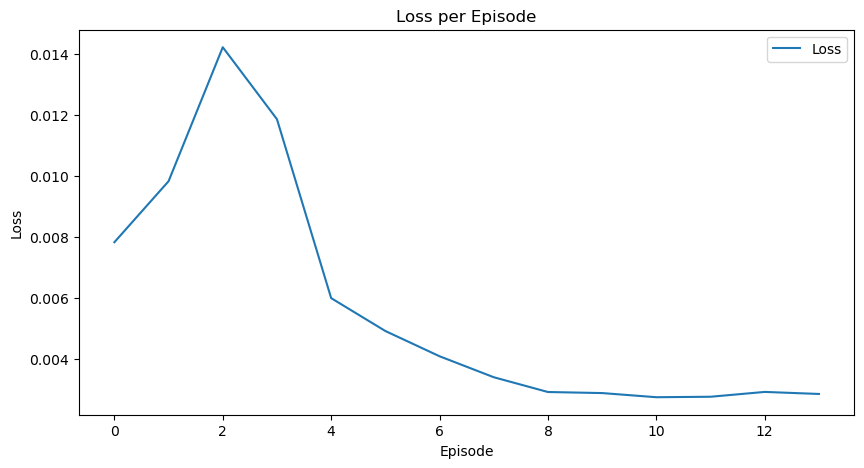

In [72]:
# Train the DQN agent
rewards, losses = train_dqn_agent(env, agent, n_episodes=100, max_steps_per_episode=300, stop_loss_threshold=0.0001)

In [73]:
def test_dqn_agent(env, agent, n_episodes=5, max_steps_per_episode=100):
    """
    Test the DQN agent in the environment for a given number of episodes with visualization.

    Args:
        env: The environment to test in.
        agent: The DQN agent.
        n_episodes: Number of episodes to run.
        max_steps_per_episode: Maximum number of steps per episode.

    Returns:
        total_rewards: List of total rewards obtained in each episode.
    """
    total_rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Clear the previous plot
            clear_output(wait=True)

            # Plot the environment
            plt.figure(figsize=(8, 8))
            plt.xlim(0, env.area_size)
            plt.ylim(0, env.area_size)
            plt.scatter(env.users[:, 0], env.users[:, 1], color='blue', label='Users')
            plt.scatter(env.uavs[:, 0], env.uavs[:, 1], color='red', label='UAVs')

            # Calculate and plot distances/rewards
            total_coverage = np.zeros(env.users.shape[0])
            for i, uav in enumerate(env.uavs):
                distances = np.linalg.norm(env.users - uav, axis=1)
                coverage = np.exp(-distances)  # Exponential decay with distance
                total_coverage += coverage

                for j, user in enumerate(env.users):
                    plt.plot([uav[0], user[0]], [uav[1], user[1]], 'k-', lw=0.5)
                    plt.text((uav[0] + user[0]) / 2, (uav[1] + user[1]) / 2, f'{coverage[j]:.2f}', fontsize=8, color='green')

            # Plot coverage as a color intensity for each user
            plt.scatter(env.users[:, 0], env.users[:, 1], c=total_coverage, cmap='coolwarm', s=200, alpha=0.6, edgecolor='black')
            plt.colorbar(label='Coverage Intensity')

            plt.title(f'Episode {episode + 1}, Step {step + 1}')
            plt.legend()
            plt.show()

            state = next_state

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}/{n_episodes} | Total Reward: {total_reward:.2f}")

    avg_reward = np.mean(total_rewards)
    print(f"\nAverage Reward over {n_episodes} Test Episodes: {avg_reward:.2f}")

    return total_rewards

In [74]:
test_rewards = test_dqn_agent(env, agent, n_episodes=15, max_steps_per_episode=100)

KeyboardInterrupt: 